# Librerías necesarias

In [ ]:
!pip install -r requirements.txt
!pip install utils.py

In [ ]:
!pip install unzip
!unzip corpusCine.zip

In [5]:

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

# Carga de datos

In [3]:
# Path al directorio donde tenemos los datasets con las reviews
# ¡Descomprimir antes!
datasets_path = './'
corpus_cine_folder = 'corpusCine'

In [6]:
reviews_dict = load_cinema_reviews(datasets_path, corpus_cine_folder)

In [ ]:
reviews_dict.get(10)

In [8]:
reviews_text = []
reviews_sentiment = []

for review in reviews_dict.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('sentiment'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df.head()

,review,sentiment
0,Cada vez me gusta menos el cine de masas. Las ...,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3
2,"Es que no la cagan en ninguna, todas las pelis...",5
3,Es un dolor esto del cine. Yo ya voy con miedo...,2
4,"Tras una insufrible primera media hora, la cas...",2


In [10]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [11]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [12]:
df.head()

,review,sentiment,sentiment_label
0,Cada vez me gusta menos el cine de masas. Las ...,1,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3,0
2,"Es que no la cagan en ninguna, todas las pelis...",5,0
3,Es un dolor esto del cine. Yo ya voy con miedo...,2,1
4,"Tras una insufrible primera media hora, la cas...",2,1


# Separamos en conjunto de train y test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [14]:
X_train.iloc[:10]

1924    Zhang Yimou ya no es el poeta de lo íntimo, el...
3250    Las aventuras amorosas del joven Molire es el ...
1620    El cientifismo naturalista es un género cinema...
907     Quizá esperaba una crítica más demoledora del ...
1864    Colateral de Michael Mann desnuda con claridad...
3007    No es Gracia Querejeta una directora a la que ...
1583    Esta es una de esas extrañas películas que emp...
370     Suele ocurrir que cuando alguien pone las expe...
2045    Vivian vive en Bucarest, trabaja en una tienda...
3601    Algunos filmes pasan a ser de culto por un hec...
Name: review, dtype: object

In [15]:
y_train.iloc[:10]

1924    0
3250    0
1620    1
907     1
1864    0
3007    0
1583    0
370     0
2045    1
3601    1
Name: sentiment_label, dtype: int64

# Extracción de features

In [16]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

In [17]:
print(list(cv.vocabulary_.items())[:20])

[('ya', 2493), ('lo', 1349), ('director', 683), ('alla', 102), ('primeros', 1845), ('ahora', 83), ('visual', 2460), ('maestro', 1376), ('cuyo', 561), ('talento', 2248), ('consiste', 457), ('belleza', 235), ('ejercicio', 748), ('bajo', 215), ('forma', 973), ('entender', 782), ('cine', 368), ('acostumbrados', 49), ('esta', 852), ('al', 86)]


In [18]:
print(len(cv.vocabulary_))

2500


## TF-IDF scores del training set y test set

In [19]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [20]:
words_example = [
    'cine',
    'pelicula',
    'muy',
    'y',
    'de',
    'que',
    'potter',
    'mala',
    'aburrimiento',
    'sorprendente',
    'aburrir',
    'ausdf'
]

In [21]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
cine                1.556
pelicula            1.154
muy                 1.532
y                   OOV                 
de                  OOV                 
que                 OOV                 
potter              5.005
mala                3.155
aburrimiento        4.727
sorprendente        4.275
aburrir             OOV                 
ausdf               OOV                 


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Palabras con el TF-IDF en alguna review

In [22]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 1982
Sentiment: 0
Review: Lúcida y divertida, Juno es la 'otra comedia adolescente', la que no deja en mal lugar a los jóvenes, resulta más real a pesar de la abrumadora carga presuntuosa de los diálogos-, convence con su mezcla de tono agridulce y picante y, sobre todo, sorprende. Que nadie le ponga la etiqueta de producto 'indie', en la senda de Pequeña Miss Sunshine, porque eso no puede más que lastrar el devenir de esta atípica cinta. Lo de atípica viene por ser deliciosa y acertadamente irreverente algo menos que Ghost World, por situarla en algún punto- en una época en la que sólo de cuando en cuando se atisba un oasis en medio de un desierto lleno de arena insulsa.El personaje de Juno y sus problemas y su capacidad, o no, para resolverlos- articula un relato sazonado con un toque justo de amargura y en el se saborean ciertas gotas de brillantez. El plato, un entrante sustancioso y original, se presenta salpicado por muestras de una galería de seres un tanto estereotipados au

In [23]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 1982:
              tfidf
juno       0.566676
eres       0.173184
adulto     0.166638
por        0.148881
algo       0.131861
aunque     0.123486
mas        0.116943
personaje  0.114662
nadie      0.105068
eso        0.103460

Top 10 words with lowest TF_IDF in the review 1982:
          tfidf
hay    0.031156
tiene  0.029515
bien   0.029479
nos    0.028455
ser    0.027785
muy    0.027078
le     0.026639
sus    0.025233
todo   0.024791
si     0.023478


## $\chi²$ scores

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


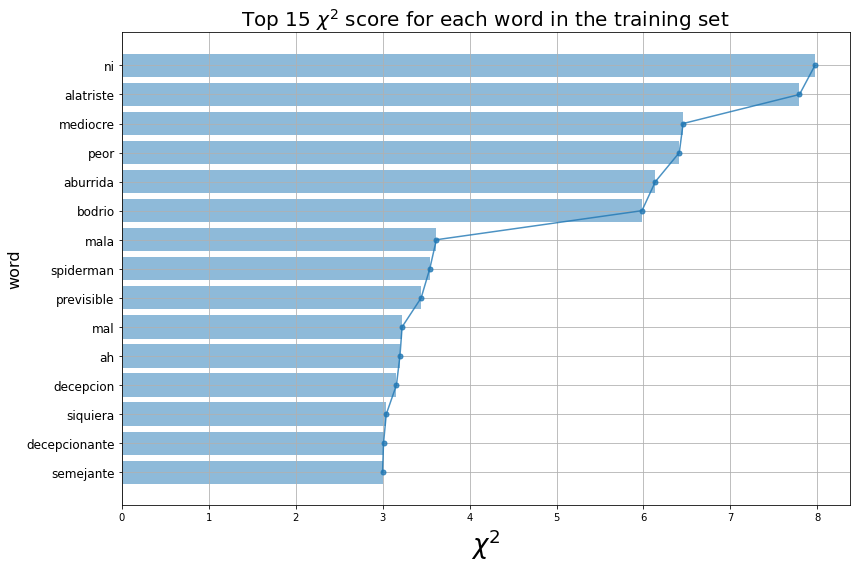

In [24]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento

In [25]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6597938144329897
Accuracy for C=0.05: 0.6597938144329897
Accuracy for C=0.25: 0.6876288659793814
Accuracy for C=0.5: 0.7381443298969073
Accuracy for C=1: 0.765979381443299
Accuracy for C=10: 0.7896907216494845
Accuracy for C=100: 0.7855670103092783
Accuracy for C=1000: 0.7680412371134021
Accuracy for C=10000: 0.756701030927835


# Algunas métricas

In [26]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[543  97]
 [139 191]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       640
           1       0.66      0.58      0.62       330

    accuracy                           0.76       970
   macro avg       0.73      0.71      0.72       970
weighted avg       0.75      0.76      0.75       970

Accuracy score:0.756701030927835


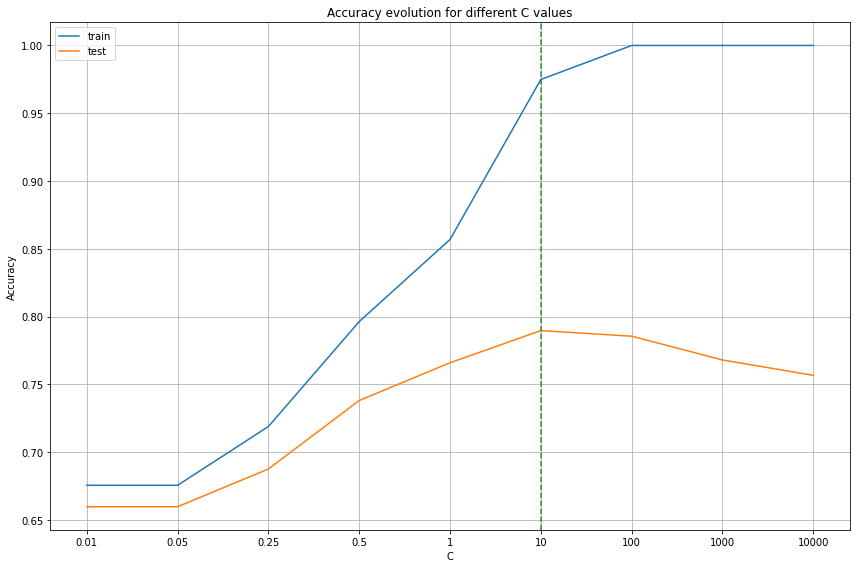

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [28]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

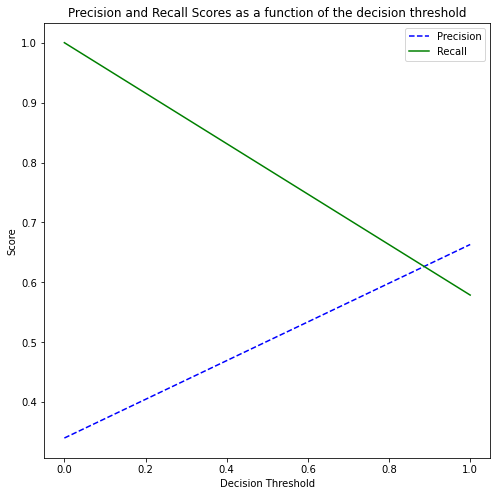

In [30]:
plot_precision_recall_vs_threshold(p, r, thresholds)

# Predict

In [31]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [32]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 480
Actual sentiment: 0
Prediction: [0]

Review no. 1262
Actual sentiment: 0
Prediction: [0]

Review no. 2078
Actual sentiment: 0
Prediction: [0]

Review no. 1544
Actual sentiment: 0
Prediction: [0]

Review no. 3292
Actual sentiment: 1
Prediction: [1]
